<h1><center>Naive Bayes - Titanic survival</center></h1>
<h2><center>Probabilistic Machine Learning</center></h2>
<img src="https://embedwistia-a.akamaihd.net/deliveries/f3d4e9ac9dbffd8ad349262f30cffada0a41f4af.jpg" width="600">

#### What are Bayesian Networks?
* In general, Bayesian Networks (BNs) is a framework for reasoning under uncertainty using probabilities. More formally, a BN is defined as a Directed Acyclic Graph (DAG) and a set of Conditional Probability Tables (CPTs). In practice, a problem domain is initially modeled as a DAG.
* Naive Bayes assumes that the variables are independent and comes from a Gaussian distribution.

#### The Bayes theorem
<img src="https://i0.wp.com/scienceprog.com/wp-content/uploads/2016/07/Thomas_Bayes.png?fit=468%2C308&ssl=1" width="400">
* P(A|B) is the posterior probability of class (A, target) given predictor (B,  attributes).
* P(A) is the prior probability of class.
* P(B|A) is the likelihood which is the probability of predictor given class.
* P(B) is the prior probability of predictor.

### Now let's apply this knowledge by building a Naive Bayes model on this data set.

### Dependencies

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

%matplotlib inline
# Suppress warnings
warnings.filterwarnings("ignore")

### Auxiliary functions

In [ ]:
def cross_validate(estimator, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))

    return train_accuracy, train_recall, train_precision, val_accuracy, val_recall, val_precision

### Load data

In [ ]:
train_raw = pd.read_csv('/content/Taitanic.csv')
test_raw = pd.read_csv('/content/Taitanic.csv')
test_ids = test_raw['PassengerId'].values

# Join data to analyse and process the set as one.
train_raw['train'] = 1
test_raw['train'] = 0
data = pd.concat([train_raw, test_raw], ignore_index=True)

### Overview the data

In [ ]:
data.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [ ]:
data.describe()

,Unnamed: 0,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train
count,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.00000
mean,445.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.50000
std,257.281582,257.281582,0.486456,0.835836,12.998365,1.102434,0.805831,49.679476,0.50014
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.00000
25%,222.250000,223.250000,0.000000,2.000000,22.000000,0.000000,0.000000,7.903100,0.00000
50%,445.000000,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,0.50000
75%,667.750000,668.750000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.00000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.00000


One advantage of Bayesian models is that it works well enough with small data, having more would give you more accurate probabilities but it's not data hungry as something like deep learning.

### Pre-process
* feature selection, data cleaning, feature engineering and data imputation

In [ ]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

data = data[features + [target] + ['train']]
# Categorical values need to be transformed into numeric.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
data['Age'] = pd.qcut(data['Age'], 10, labels=False, duplicates='drop')

In [ ]:
# Split data into train and test.
train = data.query('train == 1')
test = data.query('train == 0')

# Drop missing values from the train set.
train.dropna(axis=0, inplace=True)
labels = train[target].values

Our processed train set

In [ ]:
train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2,1.0,7.2500,0,3,1,1,0,1
1,6,2.0,71.2833,0,1,0,1,1,1
2,3,1.0,7.9250,0,3,0,0,1,1
3,6,1.0,53.1000,0,1,0,1,1,1
4,6,1.0,8.0500,0,3,1,0,0,1


### Correlation study
* As we saw Naive Bayes models expect the features to be independent, so let's apply the Pearson correlation coefficient on them to give us a hint about how independent they are from the others.

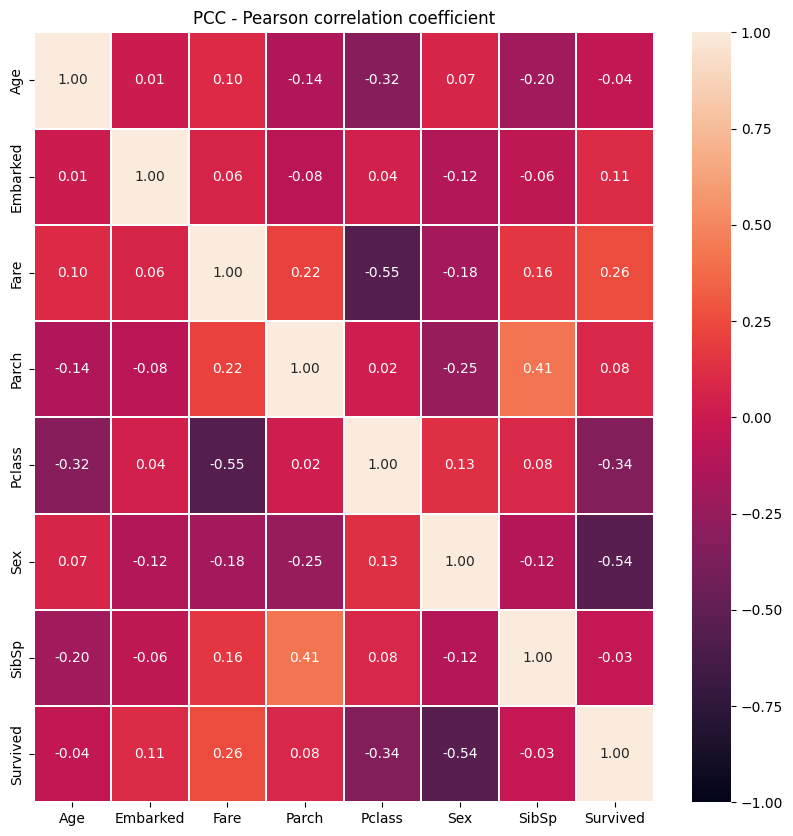

In [ ]:
columns = train[features + [target]].columns.tolist()
nColumns = len(columns)
result = pd.DataFrame(np.zeros((nColumns, nColumns)), columns=columns)

# Apply Pearson correlation on each pair of features.
for col_a in range(nColumns):
    for col_b in range(nColumns):
        result.iloc[[col_a], [col_b]] = pearsonr(train.loc[:, columns[col_a]], train.loc[:,  columns[col_b]])[0]

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(result, yticklabels=columns, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=.2)
ax.set_title('PCC - Pearson correlation coefficient')
plt.show()

About the correlation between the features, we can see that "Fare" and "Pclass" seem to be highly related, so i'll remove "Pclass". Also features like "Sex", "Pclass" and "Fare" should be good predictors.

### Distribution study
* Also the model expect the features to come from a Gaussian (or normal) distribution, so let's check that as well.

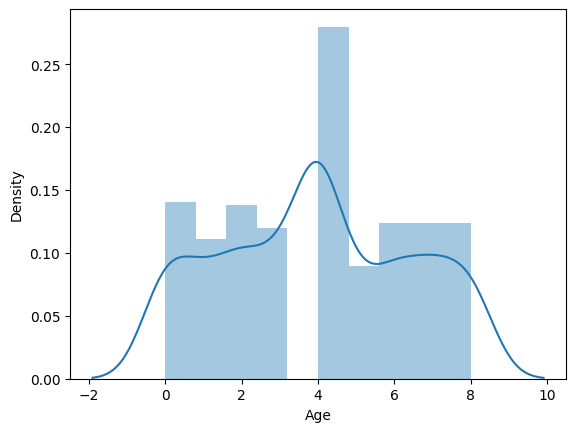

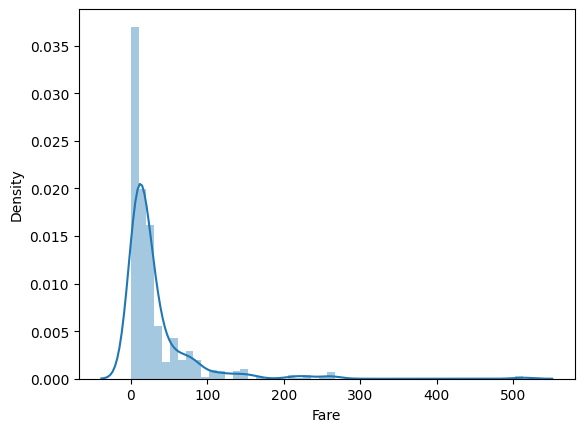

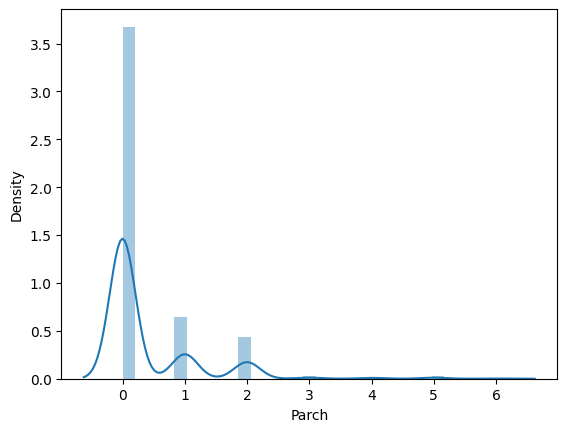

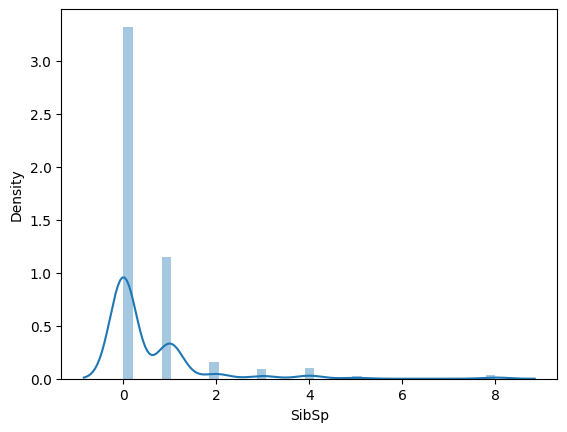

In [ ]:
continuous_numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
for feature in continuous_numeric_features:
    sns.distplot(train[feature])
    plt.show()

Looking at our continuous numeric features we can see that "Fare", "Parch" and "SibSp", have a distribution close to normal, but with a left side skew, "Age" have a distribution a a bit different from the other but maybe it's close enough to Gaussian.

In [ ]:
train.drop(['train', target, 'Pclass'], axis=1, inplace=True)
test.drop(['train', target, 'Pclass'], axis=1, inplace=True)

### Split data in train and validation (80% ~ 20%)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)

In [ ]:
X_train.head()

,Age,Embarked,Fare,Parch,Sex,SibSp
121,4,1.0,8.0500,0,1,0
687,1,1.0,10.1708,0,1,0
790,4,3.0,7.7500,0,1,0
837,4,1.0,8.0500,0,1,0
659,8,2.0,113.2750,2,1,0


### Split train data into two parts

In [ ]:
X_train1, X_train2, Y_train1, Y_train2 = train_test_split(X_train, Y_train, test_size=0.3, random_state=12)

In [ ]:
classifier = GaussianNB()

#### Fit the first part
* Fitting data here is really fast.

In [ ]:
classifier.fit(X_train2, Y_train2)

GaussianNB()

In [ ]:
print('Metrics with only 30% of train data')
train_acc_30, train_rec_30, train_prec_30, val_acc_30, val_rec_30, val_prec_30 = cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with only 30% of train data
Model metrics
Accuracy  Train: 0.78, Validation: 0.82
Recall    Train: 0.71, Validation: 0.78
Precision Train: 0.69, Validation: 0.78


#### Update the model with the second part
* Nice thing about this kind of model, you can update it by just fitting the model again with more data.

In [ ]:
classifier.partial_fit(X_train1, Y_train1)

GaussianNB()

In [ ]:
print('Metrics with the remaining 70% of train data')
train_acc_100, train_rec_100, train_prec_100, val_acc_100, val_rec_100, val_prec_100 = cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with the remaining 70% of train data
Model metrics
Accuracy  Train: 0.78, Validation: 0.85
Recall    Train: 0.73, Validation: 0.83
Precision Train: 0.68, Validation: 0.79


As you can see our results improved after we updated  the model with the remaining data.

The sklearn model also give us some interesting options from the model API about the target class.

In [ ]:
print('Probability of each class')
print('Survive = 0: %.2f' % classifier.class_prior_[0])
print('Survive = 1: %.2f' % classifier.class_prior_[1])

Probability of each class
Survive = 0: 0.62
Survive = 1: 0.38


In [ ]:
print('Mean of each feature per class')
print('               Age         Embarked   Fare         Parch       Sex         SibSp')
print('Survive = 0: %s' % classifier.theta_[0])
print('Survive = 1: %s' % classifier.theta_[1])

Mean of each feature per class
               Age         Embarked   Fare         Parch       Sex         SibSp
Survive = 0: [ 4.06081081  1.31306306 21.28715068  0.31531532  0.84459459  0.52477477]
Survive = 1: [ 3.81273408  1.46067416 44.68439513  0.50561798  0.34082397  0.49438202]


In [ ]:
print('Variance of each feature per class')
print('Survive = 0: %s' % classifier.var_[0])
print('Survive = 1: %s' % classifier.var_[1])

Variance of each feature per class
Survive = 0: [5.46251988e+00 3.95236380e-01 8.66533397e+02 6.57334627e-01
 1.31256184e-01 1.63677522e+00]
Survive = 1: [7.08852859e+00 4.35721009e-01 2.52507206e+03 6.61955070e-01
 2.24664605e-01 5.04651699e-01]


### Apply the model on the test data and create submission

In [ ]:
# Unfortunately sklearn naive Bayes algorithm currently do not make inference with missing data (but should do), so we need to input missing data.
test.fillna(test.mean(), inplace=True)
test_predictions = classifier.predict(test)
submission = pd.DataFrame({'PassengerId': test_ids})
submission['Survived'] = test_predictions.astype('int')
submission.to_csv('submission.csv', index=False)
submission.head(10)

,PassengerId,Survived
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0
5,6,0
6,7,0
7,8,0
8,9,1
9,10,1


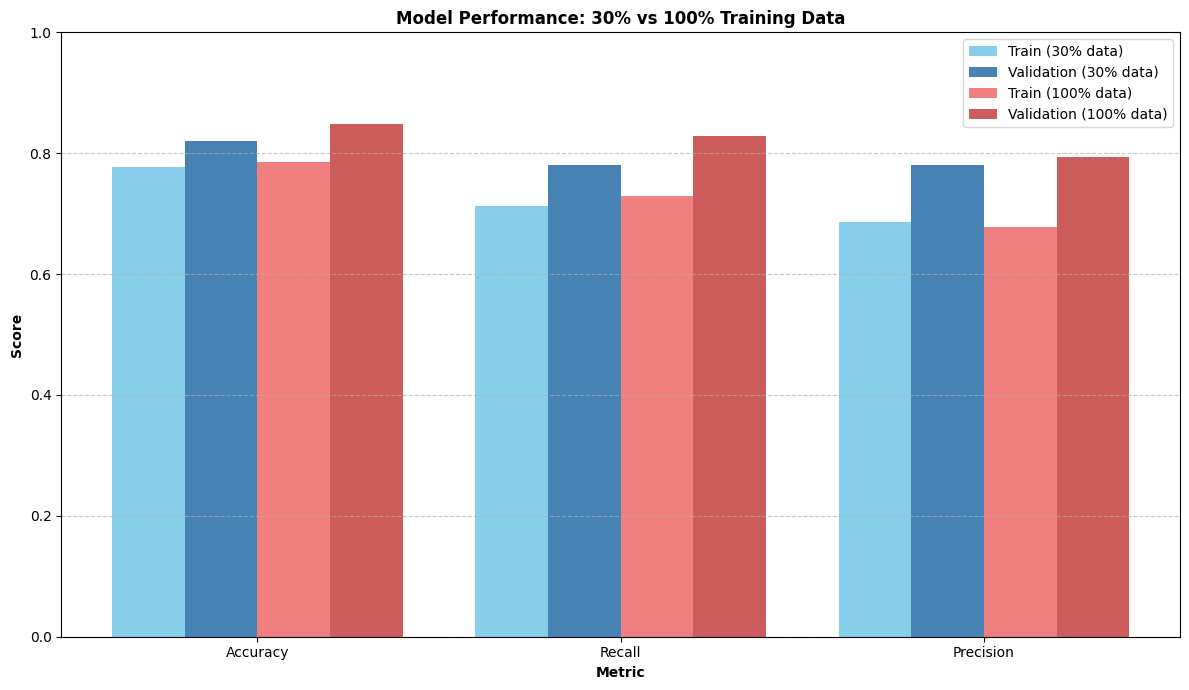

In [ ]:
metrics = ['Accuracy', 'Recall', 'Precision']

# Data for 30% train
train_30_data = [train_acc_30, train_rec_30, train_prec_30]
val_30_data = [val_acc_30, val_rec_30, val_prec_30]

# Data for 100% train
train_100_data = [train_acc_100, train_rec_100, train_prec_100]
val_100_data = [val_acc_100, val_rec_100, val_prec_100]

width = 0.2
r1 = np.arange(len(metrics))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(r1, train_30_data, width, label='Train (30% data)', color='skyblue')
ax.bar(r2, val_30_data, width, label='Validation (30% data)', color='steelblue')
ax.bar(r3, train_100_data, width, label='Train (100% data)', color='lightcoral')
ax.bar(r4, val_100_data, width, label='Validation (100% data)', color='indianred')

ax.set_xlabel('Metric', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Model Performance: 30% vs 100% Training Data', fontweight='bold')
ax.set_xticks([r + 1.5 * width for r in range(len(metrics))])
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### What are the Pros and Cons of Naive Bayes?
#### Pros:
* Humans are not good with reasoning in systems with limited or conflicting information. It would be handy if we have something to manage all this limited/conflicting information.
* It is easy and fast to predict class of test data set. It also perform well in multi class prediction
* When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data.
* It perform well in case of categorical input variables compared to numerical variable(s). For numerical variable, normal distribution is assumed (bell curve, which is a strong assumption).

#### Cons:
* Probably the most notable weakness of BNs is the designing methodology.There is no standard way of building BNs.
* If categorical variable has a category (in test data set), which was not observed in training data set, then model will assign a 0 (zero) probability and will be unable to make a prediction. This is often known as “Zero Frequency”. To solve this, we can use the smoothing technique. One of the simplest smoothing techniques is called Laplace estimation.
* On the other side naive Bayes is also known as a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.
* Another limitation of Naive Bayes is the assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.

##### The design of a BN can be a considerable amount of effort in complex systems and it is based on the knowledge of the expert(s) who designed it. Although, this disadvantage can be good in another point of view, since BNs can be easily inspected by the designers and has the guarantee that the domain specific information is being used.

### Tips to improve the power of Naive Bayes Model
#### Here are some tips for improving power of Naive Bayes Model:

* If continuous features do not have normal distribution, we should use transformation or different methods to convert it in normal distribution.
* If test data set has zero frequency issue, apply smoothing techniques “Laplace Correction” to predict the class of test data set.
* Remove correlated features, as the highly correlated features are voted twice in the model and it can lead to over inflating importance.
* Naive Bayes classifiers has limited options for parameter tuning like alpha=1 for smoothing, fit_prior=[True|False] to learn class prior probabilities or not and some other options (look at detail here). I would recommend to focus on your  pre-processing of data and the feature selection.
* You might think to apply some classifier combination technique like ensembling, bagging and boosting but these methods would not help. Actually, “ensembling, boosting, bagging” won’t help since their purpose is to reduce variance. Naive Bayes has no variance to minimize.


### References
* [Introduction to Bayesian Networks with Jhonatan de Souza Oliveira - Machine Learning Mastery](https://machinelearningmastery.com/introduction-to-bayesian-networks-with-jhonatan-de-souza-oliveira/)
* [6 Easy Steps to Learn Naive Bayes Algorithm (with codes in Python and R) - Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/)
* [Better Naive Bayes: 12 Tips To Get The Most From The Naive Bayes Algorithm - Machine Learning Mastery](https://machinelearningmastery.com/better-naive-bayes/)

# Task
Create an interactive dashboard using `ipywidgets` to predict Titanic survival. The dashboard should include input widgets for 'Age', 'Embarked', 'Fare', 'Parch', 'Sex', and 'SibSp'. Implement a Python function that uses the trained `classifier` to predict survival based on user input from these widgets and display both the survival prediction (0 or 1) and the associated probabilities. Summarize the created interactive front-end and how to use it.

## Define Prediction Function

### Subtask:
Create a Python function that takes the current feature values as input and returns the model's survival prediction and possibly the probabilities.


**Reasoning**:
I will define a Python function `predict_survival` that takes the required features as input, creates a DataFrame, and then uses the pre-trained `classifier` to predict the survival class and its probabilities.



In [ ]:
def predict_survival(Age, Embarked, Fare, Parch, Sex, SibSp):
    # Create a DataFrame from the input parameters
    input_data = pd.DataFrame({
        'Age': [Age],
        'Embarked': [Embarked],
        'Fare': [Fare],
        'Parch': [Parch],
        'Sex': [Sex],
        'SibSp': [SibSp]
    })

    # Get the survival prediction
    prediction = classifier.predict(input_data)[0]

    # Get the probabilities of not surviving (0) and surviving (1)
    probabilities = classifier.predict_proba(input_data)[0]

    return prediction, probabilities

print("Prediction function 'predict_survival' defined successfully.")

Prediction function 'predict_survival' defined successfully.


## Create Interactive Widgets

### Subtask:
Develop `ipywidgets` for each feature ('Age', 'Embarked', 'Fare', 'Parch', 'Sex', 'SibSp') to allow user input. This will likely involve sliders for numerical values and dropdowns for categorical ones.


**Reasoning**:
I need to import `ipywidgets` and `IPython.display`, then create individual widgets for 'Age', 'Embarked', 'Fare', 'Parch', 'Sex', and 'SibSp' as specified, using `IntSlider`, `FloatSlider`, and `Dropdown` types with appropriate ranges, default values, and labels.



In [ ]:
import ipywidgets as widgets
from IPython.display import display

# 2. Create an IntSlider widget for 'Age'
age_widget = widgets.IntSlider(
    min=0,
    max=9, # 'Age' was binned into 10 categories (0-9)
    step=1,
    value=4, # Default value
    description='Age (Binned):'
)

# 3. Create a Dropdown widget for 'Embarked'
embarked_widget = widgets.Dropdown(
    options={'S': 1, 'C': 2, 'Q': 3},
    value=1, # Default to 'S'
    description='Embarked:'
)

# 4. Create a FloatSlider widget for 'Fare'
fare_widget = widgets.FloatSlider(
    min=0.0,
    max=512.33,
    step=0.1,
    value=30.0, # Reasonable default value
    description='Fare:'
)

# 5. Create an IntSlider widget for 'Parch'
parch_widget = widgets.IntSlider(
    min=0,
    max=6, # Based on data description
    step=1,
    value=0, # Default value
    description='Parch:'
)

# 6. Create a Dropdown widget for 'Sex'
sex_widget = widgets.Dropdown(
    options={'Female': 0, 'Male': 1},
    value=1, # Default to 'Male'
    description='Sex:'
)

# 7. Create an IntSlider widget for 'SibSp'
sibsp_widget = widgets.IntSlider(
    min=0,
    max=8, # Based on data description
    step=1,
    value=0, # Default value
    description='SibSp:'
)

print("Widgets for 'Age', 'Embarked', 'Fare', 'Parch', 'Sex', and 'SibSp' created successfully.")

Widgets for 'Age', 'Embarked', 'Fare', 'Parch', 'Sex', and 'SibSp' created successfully.


## Build Interactive Dashboard

### Subtask:
Combine the input widgets and the prediction function into an interactive dashboard. This will include an 'Predict' button to trigger the prediction and display the results dynamically.


**Reasoning**:
I need to import the necessary `ipywidgets` classes, create the output widget and button, define the button's click handler, and then arrange and display all the widgets to build the interactive dashboard.



In [ ]:
from IPython.display import display, clear_output

# 1. Create an Output widget to display the prediction results
output_widget = widgets.Output()

# 2. Create a Button widget
predict_button = widgets.Button(
    description='Predict Survival',
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict survival'
)

# 3. Define the function to be executed when the button is clicked
def on_predict_button_clicked(button):
    with output_widget:
        clear_output()
        # Get current values from widgets
        age_val = age_widget.value
        embarked_val = embarked_widget.value
        fare_val = fare_widget.value
        parch_val = parch_widget.value
        sex_val = sex_widget.value
        sibsp_val = sibsp_widget.value

        # Call the prediction function
        prediction, probabilities = predict_survival(
            age_val, embarked_val, fare_val, parch_val, sex_val, sibsp_val
        )

        # Display the results
        print(f"--- Prediction Result ---")
        if prediction == 1:
            print(f"Survival Prediction: SURVIVED (1)")
        else:
            print(f"Survival Prediction: DID NOT SURVIVE (0)")
        print(f"Probability of Not Surviving (0): {probabilities[0]:.2f}")
        print(f"Probability of Surviving (1): {probabilities[1]:.2f}")
        print("-------------------------")

# 4. Register the on_predict_button_clicked function as the callback for the button's on_click event
predict_button.on_click(on_predict_button_clicked)

# 5. Arrange the input widgets and the button using VBox and HBox
input_widgets_layout = widgets.VBox([
    age_widget,
    embarked_widget,
    fare_widget,
    parch_widget,
    sex_widget,
    sibsp_widget
])

display(input_widgets_layout, predict_button, output_widget)

print("Interactive dashboard created successfully. Use the widgets to input values and click 'Predict Survival' to see the results.")

Button(button_style='success', description='Predict Survival', style=ButtonStyle(), tooltip='Click to predict …

Output()

Interactive dashboard created successfully. Use the widgets to input values and click 'Predict Survival' to see the results.


## Final Task

### Subtask:
Summarize the interactive front-end created and how to use it to get predictions from the Naive Bayes model.


## Summary:

### Q&A

The interactive front-end is an `ipywidgets` dashboard designed for predicting Titanic survival using a Naive Bayes model.

To use it:
1.  **Input Features**: Adjust the sliders and dropdown menus for the following passenger features: 'Age (Binned)', 'Embarked', 'Fare', 'Parch' (number of parents/children aboard), 'Sex', and 'SibSp' (number of siblings/spouses aboard).
    *   'Age' is represented as a binned integer from 0 to 9.
    *   'Embarked' uses a dropdown with 'S', 'C', 'Q' options.
    *   'Sex' uses a dropdown with 'Female' and 'Male' options.
2.  **Trigger Prediction**: Click the 'Predict Survival' button.
3.  **View Results**: The prediction (SURVIVED or DID NOT SURVIVE) and the associated probabilities for both outcomes will be displayed directly below the button.

### Data Analysis Key Findings

*   A `predict_survival` function was successfully implemented, taking six passenger features as input and returning the model's survival prediction (0 or 1) and the probabilities for each outcome.
*   Interactive `ipywidgets` were created for all six input features: 'Age' (IntSlider, 0-9), 'Embarked' (Dropdown, S:1, C:2, Q:3), 'Fare' (FloatSlider, 0.0-512.33), 'Parch' (IntSlider, 0-6), 'Sex' (Dropdown, Female:0, Male:1), and 'SibSp' (IntSlider, 0-8).
*   An interactive dashboard was successfully assembled, combining the input widgets with a 'Predict Survival' button and an output area.
*   The dashboard dynamically displays the survival prediction (e.g., "SURVIVED (1)") and the probabilities for both "Not Surviving (0)" and "Surviving (1)" when the button is clicked.

### Insights or Next Steps

*   The interactive dashboard provides a user-friendly interface for exploring the Naive Bayes model's predictions, allowing for immediate feedback on how different passenger attributes might influence survival.
*   Next steps could involve integrating this dashboard into a larger application or evaluating the model's performance more rigorously with new data through A/B testing or user studies.
